In [1]:
#Import Libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data into a pandas DataFrame
data = pd.read_csv('Downloads/cci301.csv')

In [3]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' column as the index
data.set_index('Date', inplace=True)

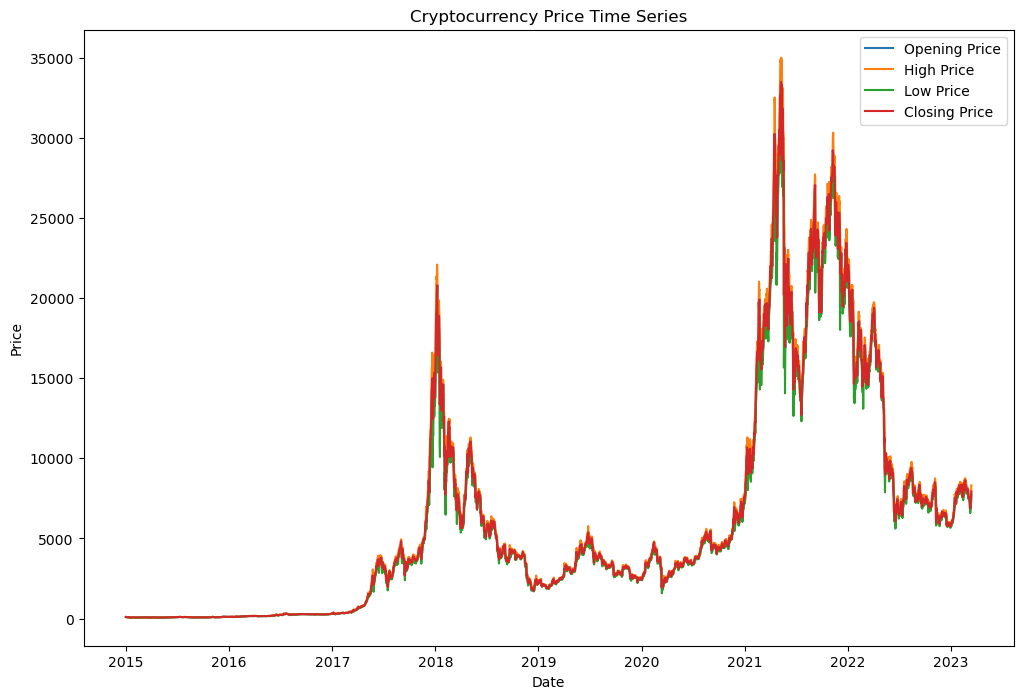

In [4]:
# Plot the variables
plt.figure(figsize=(12, 8))
sns.lineplot(data=data, x=data.index, y='Open', label='Opening Price')
sns.lineplot(data=data, x=data.index, y='High', label='High Price')
sns.lineplot(data=data, x=data.index, y='Low', label='Low Price')
sns.lineplot(data=data, x=data.index, y='Close', label='Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Cryptocurrency Price Time Series')
plt.legend()
plt.show()

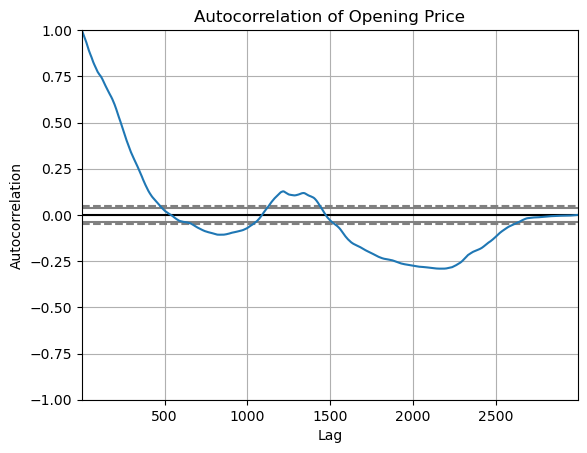

In [5]:
from pandas.plotting import autocorrelation_plot

# Plot autocorrelation for 'Open' price
autocorrelation_plot(data['Open'])
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Opening Price')
plt.show()

<Figure size 1200x800 with 0 Axes>

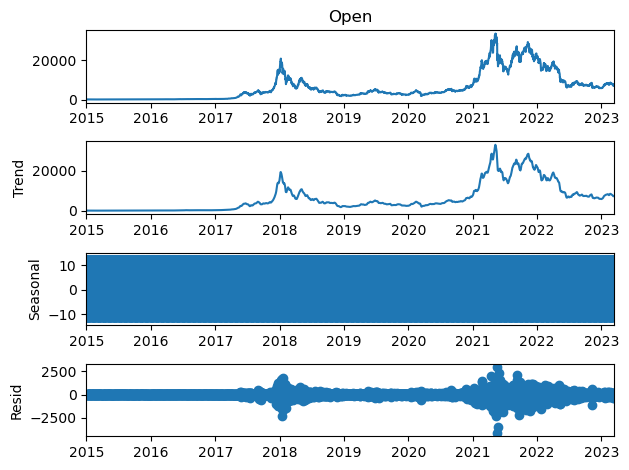

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition on 'Open' price
result = seasonal_decompose(data['Open'], model='additive')

# Plot the decomposition components
plt.figure(figsize=(12, 8))
result.plot()
plt.show()

In [7]:
# Min-Max scaling for 'Open', 'High', 'Low', and 'Close' prices
data[['Open', 'High', 'Low', 'Close']] = (data[['Open', 'High', 'Low', 'Close']] - data[['Open', 'High', 'Low', 'Close']].min()) / (data[['Open', 'High', 'Low', 'Close']].max() - data[['Open', 'High', 'Low', 'Close']].min())

In [14]:
import numpy as np

# Prepare the data for modeling
data_for_model = data['Open'].dropna().values.reshape(-1, 1)

# Define the number of regimes
n_regimes = 2

# Define the initial state probabilities
initial_probs = np.array([1 / n_regimes] * n_regimes)

# Define the transition probabilities
transition_probs = np.array([[0.8, 0.2],
                             [0.2, 0.8]])

# Define the emission probabilities (observation probabilities)
# In this example, we assume Gaussian emissions with fixed parameters (mean and standard deviation)
emission_means = np.array([np.mean(data_for_model)] * n_regimes)
emission_stds = np.array([np.std(data_for_model)] * n_regimes)

In [15]:
# Define the Markov Switching Model
def markov_switching_model(data, initial_probs, transition_probs, emission_means, emission_stds):
    n_obs = len(data)
    n_regimes = len(initial_probs)

    # Initialize arrays to store intermediate results
    alpha = np.zeros((n_obs, n_regimes))
    beta = np.zeros((n_obs, n_regimes))
    gamma = np.zeros((n_obs, n_regimes))

    # Forward pass (alpha recursion)
    alpha[0, :] = initial_probs * np.exp(-0.5 * ((data[0] - emission_means) / emission_stds) ** 2)
    for t in range(1, n_obs):
        for j in range(n_regimes):
            alpha[t, j] = np.dot(alpha[t - 1, :], transition_probs[:, j]) * \
                          np.exp(-0.5 * ((data[t] - emission_means[j]) / emission_stds[j]) ** 2)

    # Backward pass (beta recursion)
    beta[-1, :] = 1.0
    for t in range(n_obs - 2, -1, -1):
        for j in range(n_regimes):
            beta[t, j] = np.sum(transition_probs[j, :] * np.exp(-0.5 * ((data[t + 1] - emission_means) / emission_stds) ** 2) *
                                beta[t + 1, :])

    # Compute gamma probabilities (normalized state probabilities)
    gamma = alpha * beta / np.sum(alpha * beta, axis=1, keepdims=True)

    return gamma

In [16]:
# Fit the Markov Switching Model
result = markov_switching_model(data_for_model, initial_probs, transition_probs, emission_means, emission_stds)

# Extract the predicted regime (state) with the highest probability
predicted_regime = np.argmax(result, axis=1)

# Make in-sample predictions
predicted_open = np.array([emission_means[predicted_regime[t]] for t in range(len(predicted_regime))])

C:\Users\nural\AppData\Local\Temp\ipykernel_221156\442325304.py:26: RuntimeWarning: invalid value encountered in true_divide
  gamma = alpha * beta / np.sum(alpha * beta, axis=1, keepdims=True)


In [17]:
# Denormalize the predicted values if needed (reverse Min-Max scaling)
# predicted_open = predicted_open * (data['Open'].max() - data['Open'].min()) + data['Open'].min()

# Print the predicted opening prices
print("Predicted Opening Prices:")
print(predicted_open)

Predicted Opening Prices:
[0.18146352 0.18146352 0.18146352 ... 0.18146352 0.18146352 0.18146352]


In [18]:
# Define a threshold for regime (state) classification
threshold = 0.5

# Initialize arrays to store bull and bear market periods
bull_periods = []
bear_periods = []

# Determine bull and bear market periods based on predicted regime (state)
for i in range(1, len(predicted_regime)):
    # If the current regime (state) is different from the previous regime (state)
    if predicted_regime[i] != predicted_regime[i - 1]:
        # If the current regime (state) is higher than the threshold, classify as bull market
        if result[i, predicted_regime[i]] > threshold:
            bull_periods.append(i)
        # If the current regime (state) is lower than the threshold, classify as bear market
        else:
            bear_periods.append(i)

In [19]:
# Print the bull and bear market periods
print("Bull Market Periods (Indices):")
print(bull_periods)
print("Bear Market Periods (Indices):")
print(bear_periods)

Bull Market Periods (Indices):
[]
Bear Market Periods (Indices):
[]


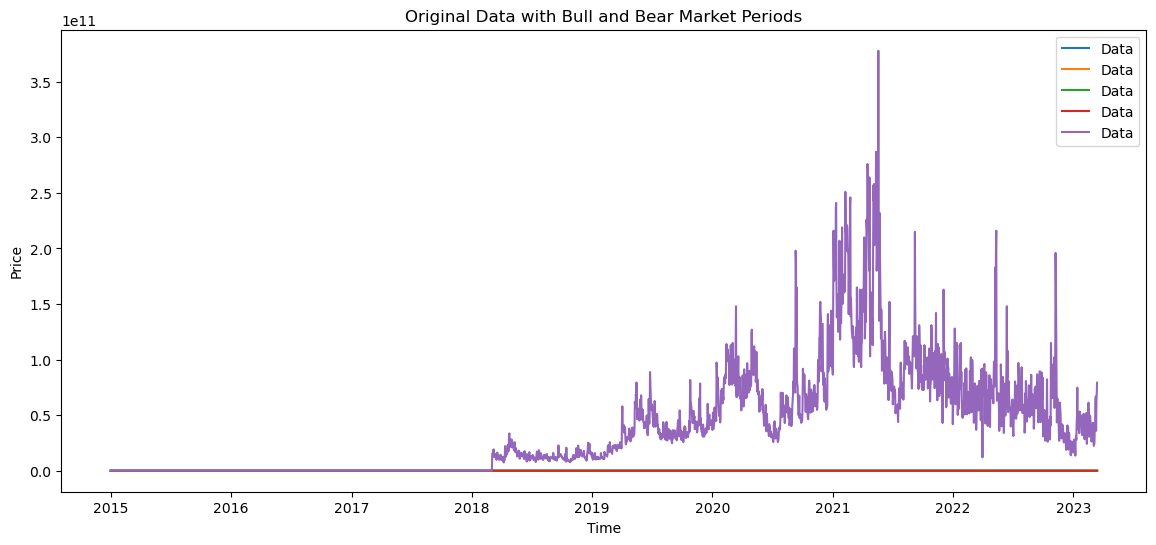

In [27]:
# Plot the original data
plt.figure(figsize=(14, 6))
plt.plot(data, label='Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Original Data with Bull and Bear Market Periods')
plt.legend()

# Plot vertical lines to indicate bull market periods
for period in bull_periods:
    plt.axvline(x=period, color='green', linestyle='--', alpha=0.5)

# Plot vertical lines to indicate bear market periods
for period in bear_periods:
    plt.axvline(x=period, color='red', linestyle='--', alpha=0.5)

# Show the plot
plt.show()

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

# Define a function to implement the Markov Switching Model
def markov_switching_model(data, num_regimes):
    """
    Implements a simple Markov Switching Model with a given number of regimes (states).

    Args:
        data (array): 1D array of observed data
        num_regimes (int): Number of regimes (states) in the model

    Returns:
        predicted_regimes (array): Predicted regimes (0 for bear, 1 for bull)
    """

    # Estimate regime probabilities using maximum likelihood estimation
    n = len(data)
    M = np.zeros((n, num_regimes))
    M[0] = 1 / num_regimes
    for t in range(1, n):
        M[t] = M[t - 1] @ P.T

    # Forward algorithm
    alpha = np.zeros((n, num_regimes))
    alpha[0] = M[0] * pi
    for t in range(1, n):
        alpha[t] = M[t] * (A.T @ alpha[t - 1])
        alpha[t] /= np.sum(alpha[t])

    # Backward algorithm
    beta = np.zeros((n, num_regimes))
    beta[-1] = 1
    for t in range(n - 2, -1, -1):
        beta[t] = A @ (M[t + 1] * beta[t + 1])
        beta[t] /= np.sum(beta[t])

    # Compute smoothed probabilities
    gamma = alpha * beta
    gamma /= np.sum(gamma, axis=1, keepdims=True)

    # Predict regimes based on smoothed probabilities
    predicted_regimes = gamma.argmax(axis=1)

    return predicted_regimes

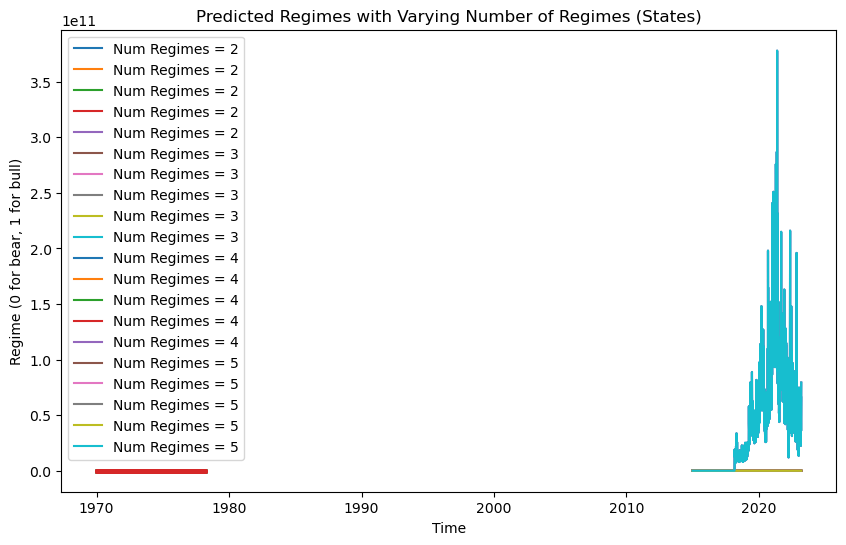

In [26]:
 # Define the number of regimes to test
num_regimes_range = range(2, 6)  # Test 2 to 5 regimes

# Initialize an empty list to store the predicted regimes for each regime count
predicted_regimes_list = []

# Loop through the number of regimes
for num_regimes in num_regimes_range:
    # Define transition probabilities for the current number of regimes
    P = np.random.rand(num_regimes, num_regimes)
    P /= np.sum(P, axis=1, keepdims=True)
    
    # Define initial regime probabilities
    pi = np.ones(num_regimes) / num_regimes

    # Define regime transition matrix
    A = np.random.rand(num_regimes, num_regimes)
    A /= np.sum(A, axis=1, keepdims=True)
    
    # Call the markov_switching_model function with the current number of regimes
    predicted_regimes = markov_switching_model(data, num_regimes)
    predicted_regimes_list.append(predicted_regimes)

# Plot the predicted regimes for each regime count
plt.figure(figsize=(10, 6))
for i in range(len(num_regimes_range)):
    plt.plot(data, label=f'Num Regimes = {num_regimes_range[i]}')
    plt.scatter(range(len(data)), predicted_regimes_list[i], marker='o', s=5)
plt.xlabel('Time')
plt.ylabel('Regime (0 for bear, 1 for bull)')
plt.title('Predicted Regimes with Varying Number of Regimes (States)')
plt.legend()
plt.show()